# Optimization WFA - Linear Regression

## Linear Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

In [5]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [6]:
XAUUSD = load_data()

In [7]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [8]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


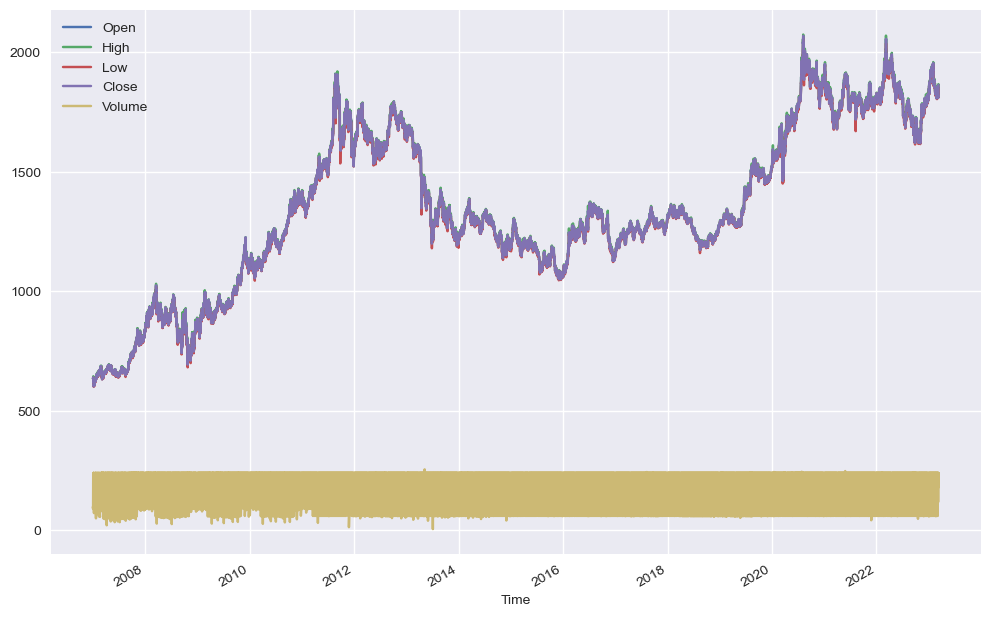

In [9]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [10]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [11]:
mainFolder = 'Machine_Learning'
strategy = Linear_Regression
strategyName = 'Linear_Regression'
account_size = 1000
folder_ML_Strategy = 'Linear Regression'
subFolder = 'Optimization'

In [12]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [13]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size , account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=1):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data.dropna(inplace=True)
        cols = []
        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size :i ]

            lm = LinearRegression(fit_intercept=True)
            lm.fit(rolling_window_data[cols], rolling_window_data['returns'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()


    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy, cash = account_size  , margin= 1/100)
        result = backtest.run()
        return result

    

    def Run(self) :
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [15]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [16]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [17]:
test = ml.Run()

In [18]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   94.981155
Equity Final [$]                      882.915
Equity Peak [$]                      1443.069
Return [%]                           -11.7085
Buy & Hold Return [%]              197.493146
Return (Ann.) [%]                   -0.620575
Volatility (Ann.) [%]               26.693263
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -72.168037
Avg. Drawdown [%]                  -16.423169
Max. Drawdown Duration     3270 days 00:00:00
Avg. Drawdown Duration      374 days 00:00:00
# Trades                                 1251
Win Rate [%]                        49.640288
Best Trade [%]                      14.510237
Worst Trade [%]                    -11.881429
Avg. Trade [%]                    

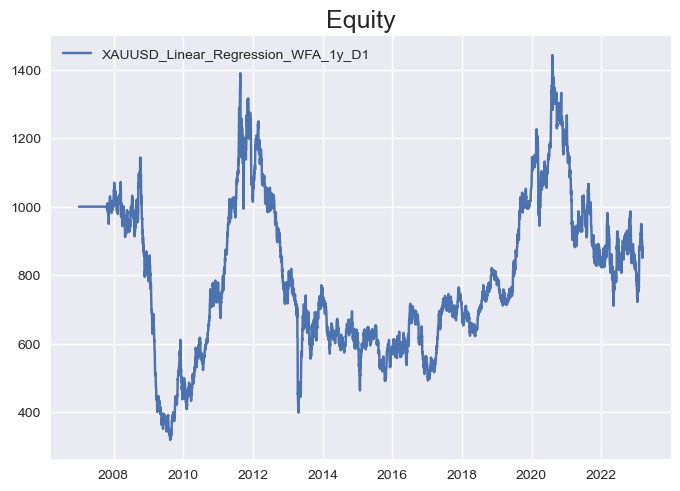

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [20]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [21]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [22]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [23]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [24]:
test = ml.Run()

In [25]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   89.982146
Equity Final [$]                     1011.466
Equity Peak [$]                      1849.512
Return [%]                             1.1466
Buy & Hold Return [%]              197.493146
Return (Ann.) [%]                    0.057009
Volatility (Ann.) [%]               15.459715
Sharpe Ratio                         0.003688
Sortino Ratio                        0.005028
Calmar Ratio                         0.001258
Max. Drawdown [%]                  -45.311736
Avg. Drawdown [%]                   -4.504732
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      143 days 00:00:00
# Trades                                  871
Win Rate [%]                        49.483352
Best Trade [%]                      51.237475
Worst Trade [%]                    -20.103874
Avg. Trade [%]                    

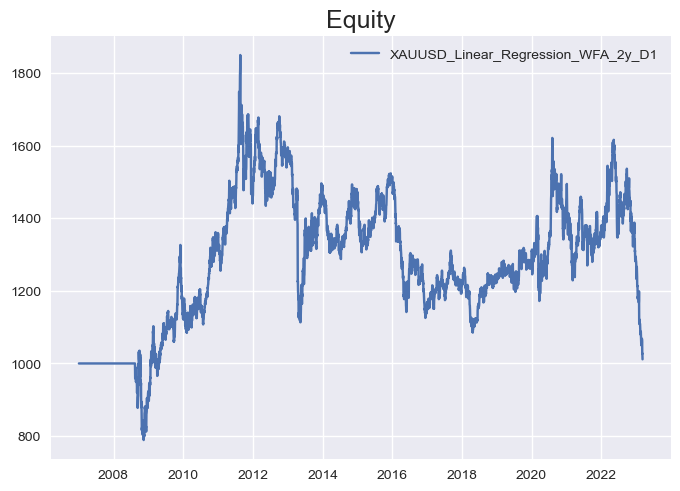

In [26]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [27]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [28]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [29]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [30]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [31]:
test = ml.Run()

In [32]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   84.983138
Equity Final [$]                     1138.967
Equity Peak [$]                      1980.037
Return [%]                            13.8967
Buy & Hold Return [%]              197.493146
Return (Ann.) [%]                      0.6526
Volatility (Ann.) [%]               13.732919
Sharpe Ratio                         0.047521
Sortino Ratio                        0.065875
Calmar Ratio                         0.013725
Max. Drawdown [%]                  -47.548859
Avg. Drawdown [%]                   -2.613317
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      106 days 00:00:00
# Trades                                  630
Win Rate [%]                        51.904762
Best Trade [%]                      19.978125
Worst Trade [%]                    -14.383633
Avg. Trade [%]                    

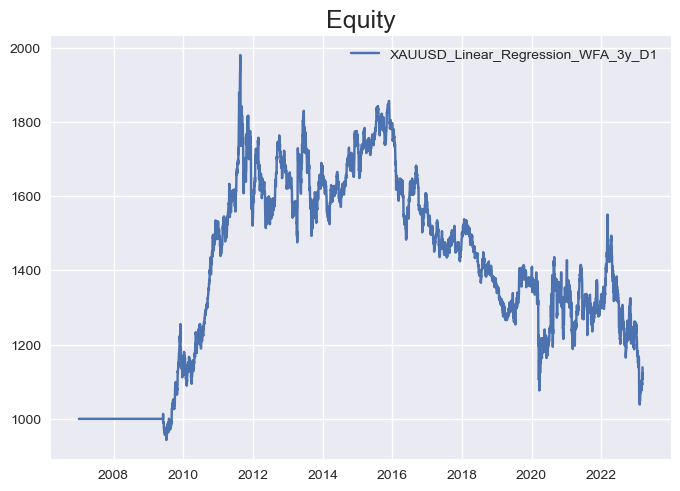

In [33]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [34]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [35]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [36]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [37]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [38]:
test = ml.Run()

In [39]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                    79.98413
Equity Final [$]                     1419.458
Equity Peak [$]                      1937.205
Return [%]                            41.9458
Buy & Hold Return [%]              197.493146
Return (Ann.) [%]                    1.766448
Volatility (Ann.) [%]               12.412192
Sharpe Ratio                         0.142316
Sortino Ratio                        0.201025
Calmar Ratio                         0.050017
Max. Drawdown [%]                  -35.316913
Avg. Drawdown [%]                   -3.470648
Max. Drawdown Duration     1428 days 00:00:00
Avg. Drawdown Duration      109 days 00:00:00
# Trades                                  647
Win Rate [%]                        55.486862
Best Trade [%]                      16.878292
Worst Trade [%]                     -10.97486
Avg. Trade [%]                    

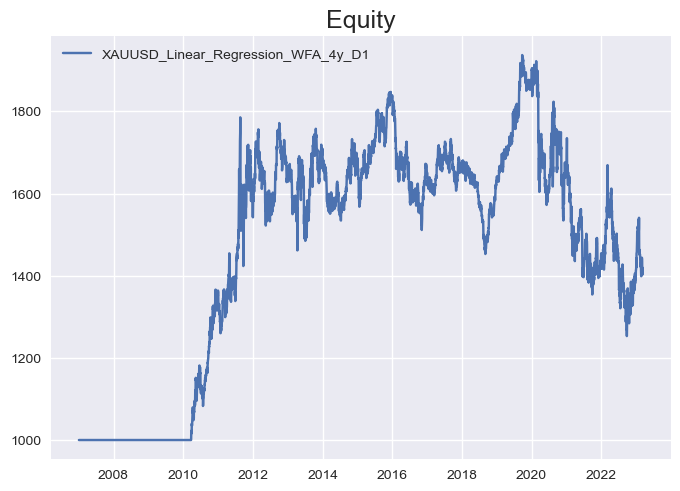

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [41]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [42]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [43]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [44]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [45]:
test = ml.Run()

In [46]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   74.985122
Equity Final [$]                     1247.425
Equity Peak [$]                      1605.125
Return [%]                            24.7425
Buy & Hold Return [%]              197.493146
Return (Ann.) [%]                    1.111318
Volatility (Ann.) [%]                16.42104
Sharpe Ratio                         0.067676
Sortino Ratio                        0.096536
Calmar Ratio                         0.023516
Max. Drawdown [%]                  -47.257636
Avg. Drawdown [%]                   -6.442146
Max. Drawdown Duration     3270 days 00:00:00
Avg. Drawdown Duration      221 days 00:00:00
# Trades                                  587
Win Rate [%]                         54.51448
Best Trade [%]                      17.138616
Worst Trade [%]                    -11.948028
Avg. Trade [%]                    

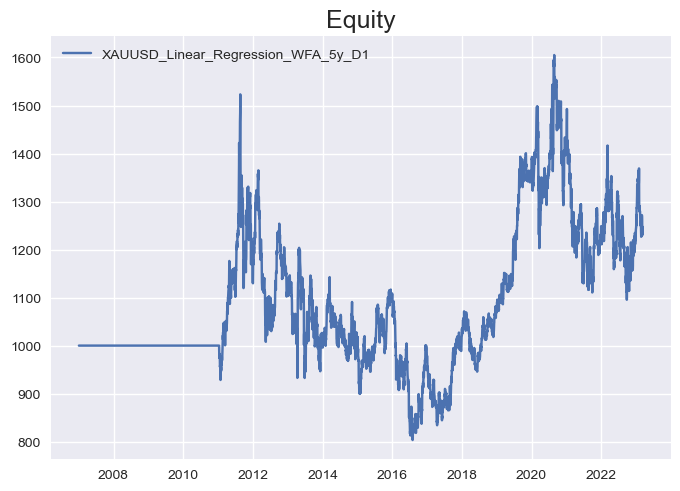

In [47]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [48]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [49]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [50]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [51]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [52]:
test = ml.Run()

In [53]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   69.986114
Equity Final [$]                       755.49
Equity Peak [$]                      1124.003
Return [%]                            -24.451
Buy & Hold Return [%]              197.493146
Return (Ann.) [%]                   -1.391888
Volatility (Ann.) [%]               27.269725
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -69.018944
Avg. Drawdown [%]                  -17.214287
Max. Drawdown Duration     3601 days 00:00:00
Avg. Drawdown Duration      691 days 00:00:00
# Trades                                  587
Win Rate [%]                        54.003407
Best Trade [%]                       9.595564
Worst Trade [%]                    -12.515366
Avg. Trade [%]                    

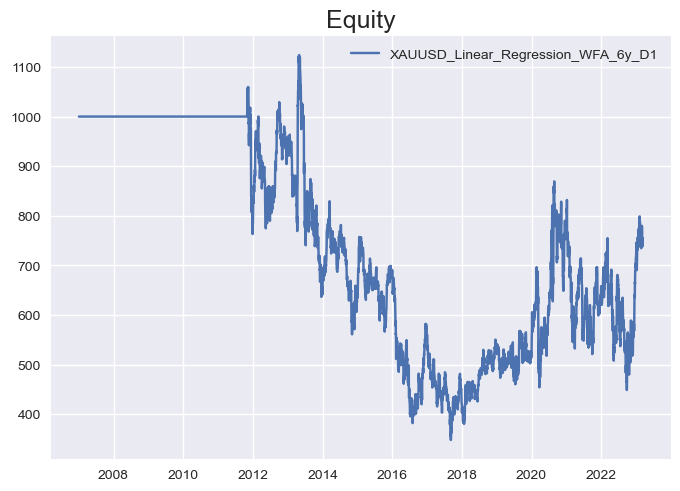

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [55]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [56]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [57]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [58]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [59]:
test = ml.Run()

In [60]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   24.360246
Equity Final [$]                       10.901
Equity Peak [$]                      1118.628
Return [%]                           -98.9099
Buy & Hold Return [%]              197.493146
Return (Ann.) [%]                  -20.220229
Volatility (Ann.) [%]               30.032817
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -99.04517
Avg. Drawdown [%]                  -13.148771
Max. Drawdown Duration     3809 days 00:00:00
Avg. Drawdown Duration      480 days 00:00:00
# Trades                                  199
Win Rate [%]                        45.226131
Best Trade [%]                       9.290183
Worst Trade [%]                    -10.985091
Avg. Trade [%]                    

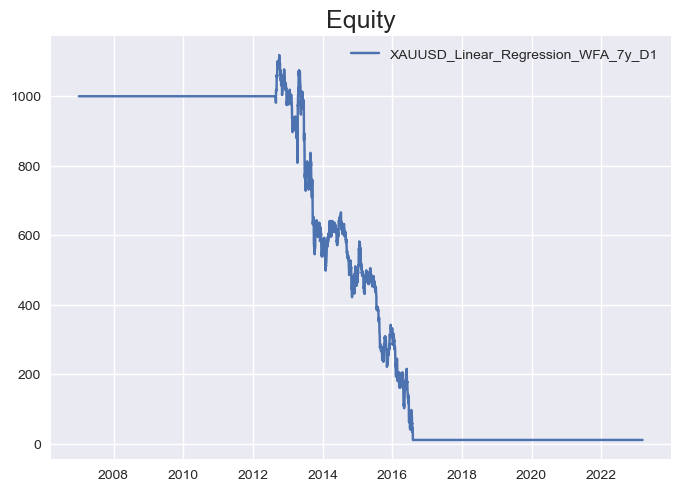

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [62]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [63]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [64]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [65]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [66]:
test = ml.Run()

In [67]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   5910 days 00:00:00
Exposure Time [%]                   59.988098
Equity Final [$]                        367.5
Equity Peak [$]                      1034.066
Return [%]                             -63.25
Buy & Hold Return [%]              197.493146
Return (Ann.) [%]                   -4.881021
Volatility (Ann.) [%]               95.242072
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.823673
Avg. Drawdown [%]                  -38.954961
Max. Drawdown Duration     3482 days 00:00:00
Avg. Drawdown Duration     1184 days 00:00:00
# Trades                                  497
Win Rate [%]                        50.704225
Best Trade [%]                      11.972571
Worst Trade [%]                    -10.409148
Avg. Trade [%]                    

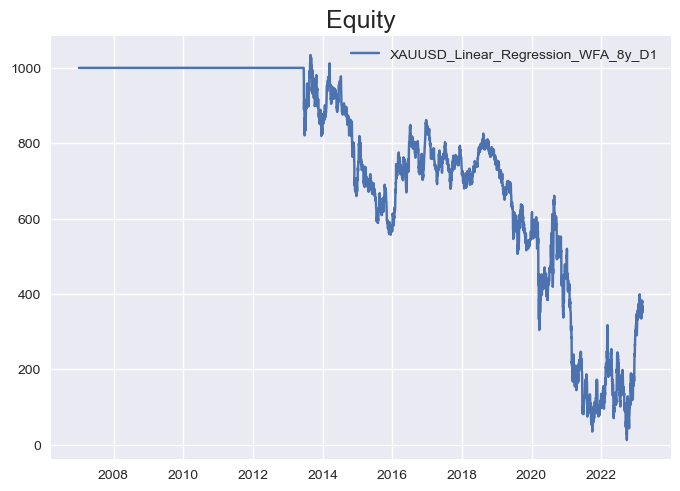

In [68]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [69]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [70]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [71]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H4'

### Window size 1 year

In [72]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [73]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [74]:
test = ml.Run()

In [75]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   94.174944
Equity Final [$]                     1200.317
Equity Peak [$]                       2049.28
Return [%]                            20.0317
Buy & Hold Return [%]              193.100396
Return (Ann.) [%]                     0.91656
Volatility (Ann.) [%]               14.459534
Sharpe Ratio                         0.063388
Sortino Ratio                        0.090557
Calmar Ratio                         0.020428
Max. Drawdown [%]                  -44.867222
Avg. Drawdown [%]                   -1.898625
Max. Drawdown Duration     2438 days 20:00:00
Avg. Drawdown Duration       39 days 06:00:00
# Trades                                 5962
Win Rate [%]                        50.285139
Best Trade [%]                      21.992951
Worst Trade [%]                    -14.498659
Avg. Trade [%]                    

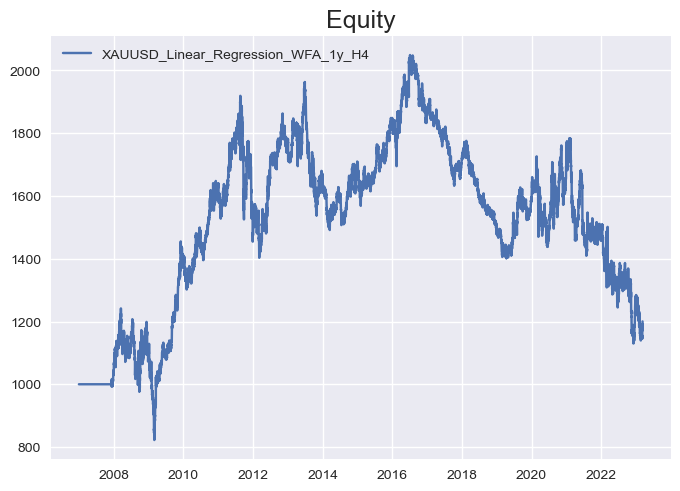

In [76]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [77]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [78]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [79]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [80]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [81]:
test = ml.Run()

In [82]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   88.353738
Equity Final [$]                     1535.178
Equity Peak [$]                       1768.79
Return [%]                            53.5178
Buy & Hold Return [%]              193.100396
Return (Ann.) [%]                    2.165061
Volatility (Ann.) [%]               15.256541
Sharpe Ratio                          0.14191
Sortino Ratio                        0.204146
Calmar Ratio                         0.055598
Max. Drawdown [%]                  -38.941468
Avg. Drawdown [%]                    -2.75367
Max. Drawdown Duration     3271 days 04:00:00
Avg. Drawdown Duration       59 days 07:00:00
# Trades                                 5199
Win Rate [%]                        50.644355
Best Trade [%]                      16.409289
Worst Trade [%]                    -10.173787
Avg. Trade [%]                    

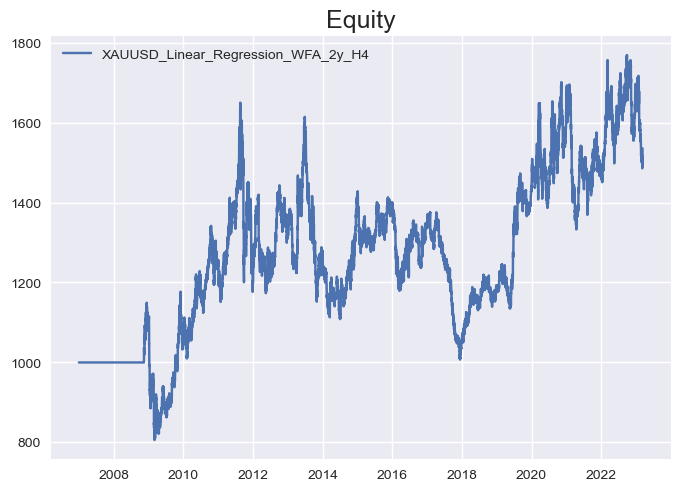

In [83]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [84]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [85]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [86]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [87]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [88]:
test = ml.Run()

In [89]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   82.532533
Equity Final [$]                      630.772
Equity Peak [$]                      1656.999
Return [%]                           -36.9228
Buy & Hold Return [%]              193.100396
Return (Ann.) [%]                   -2.276374
Volatility (Ann.) [%]               22.333717
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -73.260515
Avg. Drawdown [%]                   -2.121341
Max. Drawdown Duration     4218 days 20:00:00
Avg. Drawdown Duration       54 days 18:00:00
# Trades                                 5615
Win Rate [%]                        50.614426
Best Trade [%]                      31.217908
Worst Trade [%]                     -8.455365
Avg. Trade [%]                    

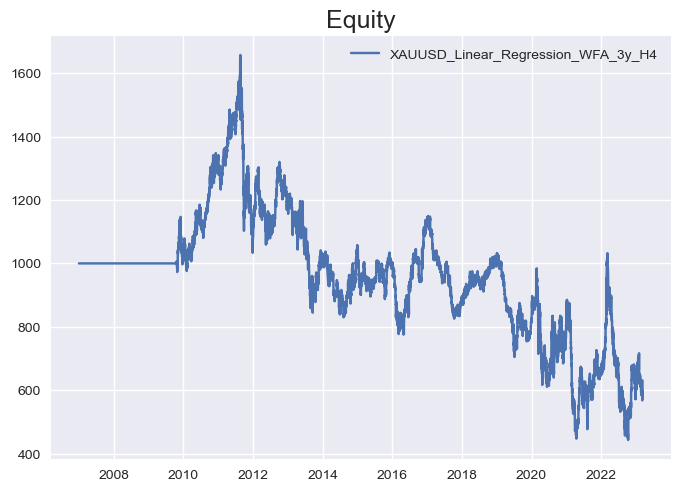

In [90]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [91]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [92]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [93]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [94]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [95]:
test = ml.Run()

In [96]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   76.711327
Equity Final [$]                      579.605
Equity Peak [$]                      1617.367
Return [%]                           -42.0395
Buy & Hold Return [%]              193.100396
Return (Ann.) [%]                   -2.688615
Volatility (Ann.) [%]               26.329613
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -83.723298
Avg. Drawdown [%]                   -2.574742
Max. Drawdown Duration     4217 days 20:00:00
Avg. Drawdown Duration       71 days 23:00:00
# Trades                                 5697
Win Rate [%]                        50.588029
Best Trade [%]                      21.440013
Worst Trade [%]                    -14.991385
Avg. Trade [%]                    

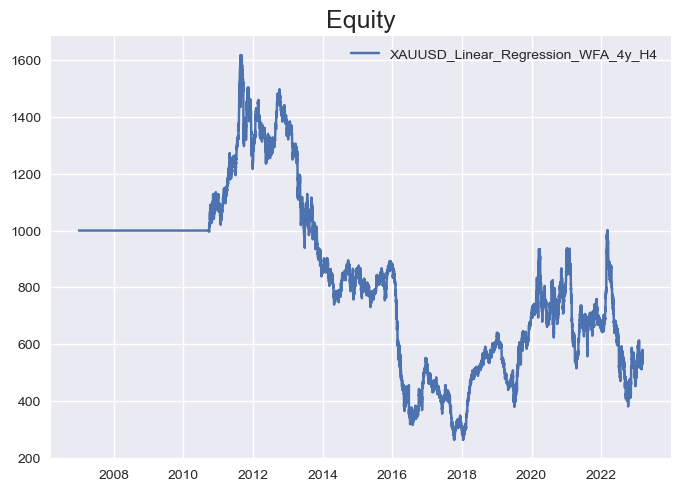

In [97]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [98]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [99]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [100]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [101]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [102]:
test = ml.Run()

In [103]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                    10.49511
Equity Final [$]                         8.35
Equity Peak [$]                       524.724
Return [%]                             -98.33
Buy & Hold Return [%]              193.100396
Return (Ann.) [%]                  -18.494168
Volatility (Ann.) [%]               34.651902
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.420122
Avg. Drawdown [%]                  -25.201885
Max. Drawdown Duration     4203 days 16:00:00
Avg. Drawdown Duration     1051 days 05:00:00
# Trades                                   33
Win Rate [%]                        39.393939
Best Trade [%]                       3.494958
Worst Trade [%]                    -21.003355
Avg. Trade [%]                    

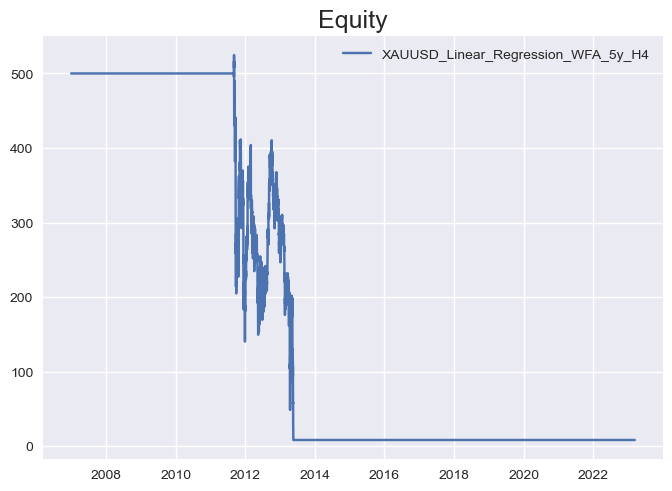

In [104]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [105]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [106]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [107]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [108]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [109]:
test = ml.Run()

In [110]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   21.756372
Equity Final [$]                        2.077
Equity Peak [$]                      1190.853
Return [%]                           -99.7923
Buy & Hold Return [%]              193.100396
Return (Ann.) [%]                  -26.556796
Volatility (Ann.) [%]               25.651241
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.825587
Avg. Drawdown [%]                   -4.223127
Max. Drawdown Duration     3808 days 16:00:00
Avg. Drawdown Duration      137 days 18:00:00
# Trades                                 1129
Win Rate [%]                        43.224092
Best Trade [%]                       6.855877
Worst Trade [%]                     -7.625162
Avg. Trade [%]                    

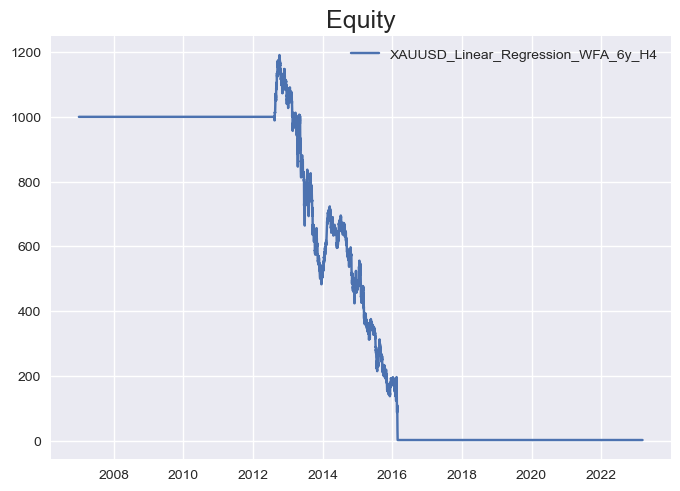

In [111]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [112]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [113]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [114]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [115]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [116]:
test = ml.Run()

In [117]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   37.256487
Equity Final [$]                       13.656
Equity Peak [$]                      1053.152
Return [%]                           -98.6344
Buy & Hold Return [%]              193.100396
Return (Ann.) [%]                  -19.309643
Volatility (Ann.) [%]               28.386955
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.703321
Avg. Drawdown [%]                  -15.845953
Max. Drawdown Duration     3481 days 12:00:00
Avg. Drawdown Duration      502 days 01:00:00
# Trades                                 1563
Win Rate [%]                        44.209853
Best Trade [%]                       6.776691
Worst Trade [%]                     -5.490625
Avg. Trade [%]                    

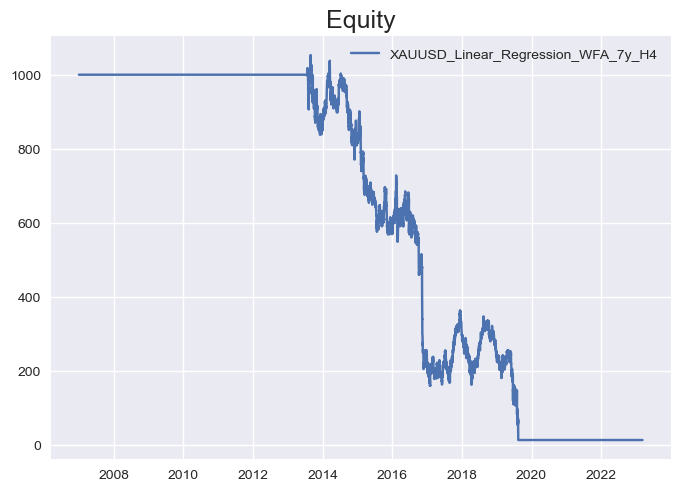

In [118]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [119]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [120]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [121]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [122]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [123]:
test = ml.Run()

In [124]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 08:00:00
Exposure Time [%]                   53.426503
Equity Final [$]                      277.564
Equity Peak [$]                      1028.234
Return [%]                           -72.2436
Buy & Hold Return [%]              193.100396
Return (Ann.) [%]                   -6.203915
Volatility (Ann.) [%]               38.201672
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -92.271993
Avg. Drawdown [%]                   -13.40859
Max. Drawdown Duration     3165 days 08:00:00
Avg. Drawdown Duration      452 days 14:00:00
# Trades                                 3399
Win Rate [%]                        50.102971
Best Trade [%]                       8.057695
Worst Trade [%]                    -11.230781
Avg. Trade [%]                    

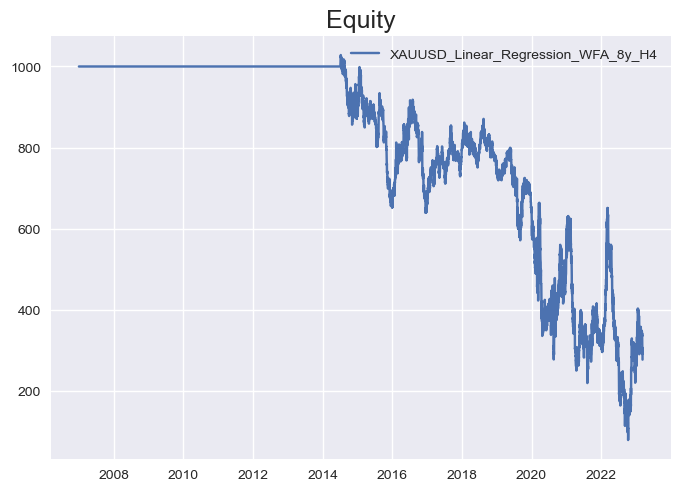

In [125]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [126]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [127]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [128]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H1'

### Window size 1 year

In [129]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [130]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [131]:
test = ml.Run()

In [132]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   93.824526
Equity Final [$]                     1681.899
Equity Peak [$]                      1863.613
Return [%]                            68.1899
Buy & Hold Return [%]               193.05616
Return (Ann.) [%]                    2.632115
Volatility (Ann.) [%]               16.414056
Sharpe Ratio                         0.160357
Sortino Ratio                        0.233855
Calmar Ratio                         0.055033
Max. Drawdown [%]                  -47.827936
Avg. Drawdown [%]                    -1.58839
Max. Drawdown Duration     3257 days 04:00:00
Avg. Drawdown Duration       29 days 17:00:00
# Trades                                26604
Win Rate [%]                        50.695384
Best Trade [%]                       8.453839
Worst Trade [%]                    -10.730146
Avg. Trade [%]                    

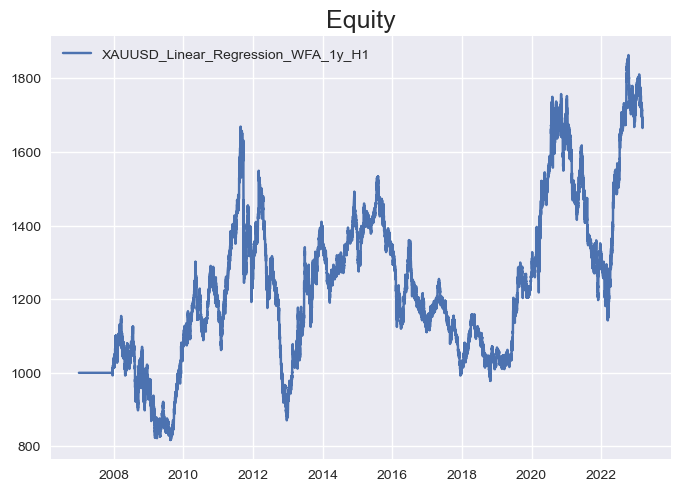

In [133]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [134]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [135]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [136]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [137]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [138]:
test = ml.Run()

In [139]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   87.650074
Equity Final [$]                     2699.319
Equity Peak [$]                      2874.659
Return [%]                           169.9319
Buy & Hold Return [%]               193.05616
Return (Ann.) [%]                    5.087215
Volatility (Ann.) [%]               11.034344
Sharpe Ratio                         0.461035
Sortino Ratio                        0.689718
Calmar Ratio                          0.12576
Max. Drawdown [%]                  -40.451634
Avg. Drawdown [%]                   -0.935297
Max. Drawdown Duration     3170 days 22:00:00
Avg. Drawdown Duration       14 days 02:00:00
# Trades                                21190
Win Rate [%]                        50.651251
Best Trade [%]                      10.227016
Worst Trade [%]                     -5.930173
Avg. Trade [%]                    

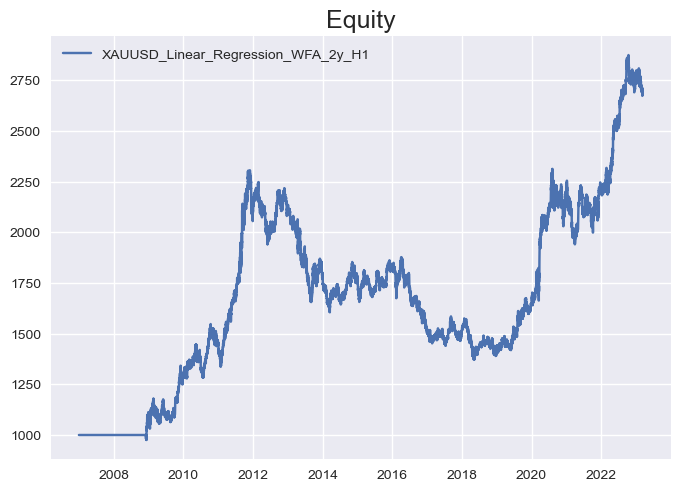

In [140]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [141]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [142]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [143]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [144]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [145]:
test = ml.Run()

In [146]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 15:00:00
Exposure Time [%]                   81.475621
Equity Final [$]                     2096.637
Equity Peak [$]                      2298.585
Return [%]                           109.6637
Buy & Hold Return [%]               193.05616
Return (Ann.) [%]                    3.768753
Volatility (Ann.) [%]               11.778107
Sharpe Ratio                          0.31998
Sortino Ratio                        0.471658
Calmar Ratio                         0.073972
Max. Drawdown [%]                  -50.948344
Avg. Drawdown [%]                   -1.044741
Max. Drawdown Duration     4053 days 09:00:00
Avg. Drawdown Duration       19 days 08:00:00
# Trades                                21336
Win Rate [%]                        49.854706
Best Trade [%]                        8.17471
Worst Trade [%]                    -14.617611
Avg. Trade [%]                    

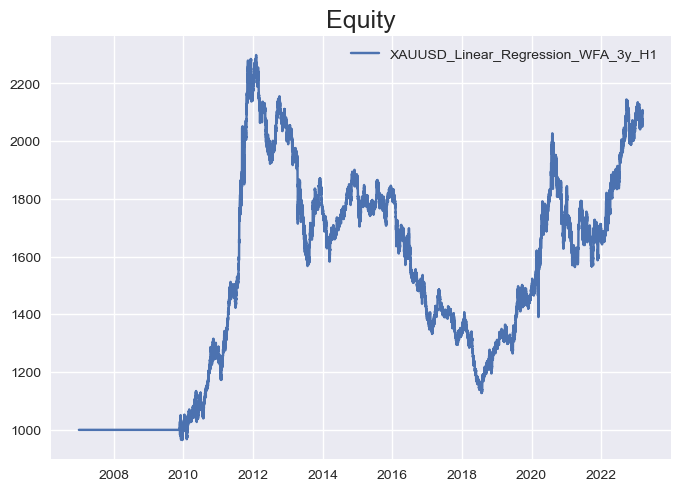

In [147]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [148]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [149]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [150]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [151]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [152]:
test = ml.Run()

KeyboardInterrupt: 

In [ ]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   75.300916
Equity Final [$]                     2009.236
Equity Peak [$]                      2553.303
Return [%]                           100.9236
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    3.548195
Volatility (Ann.) [%]               14.189915
Sharpe Ratio                          0.25005
Sortino Ratio                        0.360285
Calmar Ratio                          0.09133
Max. Drawdown [%]                   -38.85044
Avg. Drawdown [%]                   -1.153763
Max. Drawdown Duration     2992 days 07:00:00
Avg. Drawdown Duration       16 days 22:00:00
# Trades                                21615
Win Rate [%]                         51.54291
Best Trade [%]                       9.510329
Worst Trade [%]                     -7.152739
Avg. Trade [%]                    

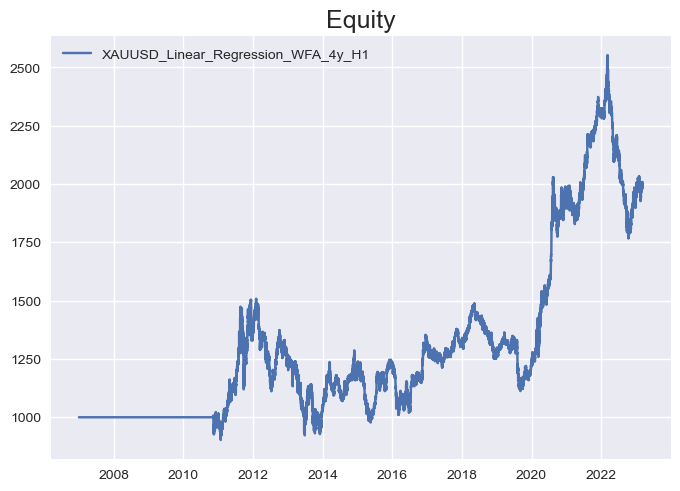

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                     69.1264
Equity Final [$]                     1340.111
Equity Peak [$]                      1777.298
Return [%]                            34.0111
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    1.473644
Volatility (Ann.) [%]               28.813217
Sharpe Ratio                         0.051145
Sortino Ratio                        0.074487
Calmar Ratio                         0.019624
Max. Drawdown [%]                   -75.09577
Avg. Drawdown [%]                   -2.081264
Max. Drawdown Duration     3188 days 14:00:00
Avg. Drawdown Duration       29 days 00:00:00
# Trades                                20001
Win Rate [%]                          52.0024
Best Trade [%]                       3.579094
Worst Trade [%]                      -5.20936
Avg. Trade [%]                    

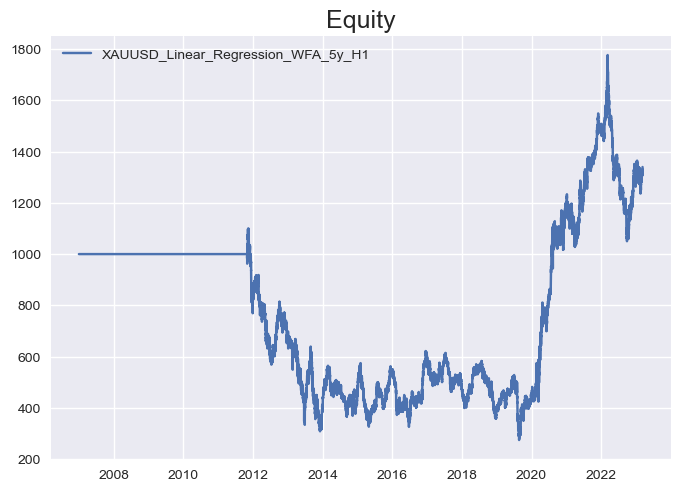

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   62.951884
Equity Final [$]                     1723.593
Equity Peak [$]                      1945.577
Return [%]                            72.3593
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    2.757778
Volatility (Ann.) [%]               18.912575
Sharpe Ratio                         0.145817
Sortino Ratio                        0.212913
Calmar Ratio                         0.051365
Max. Drawdown [%]                  -53.689887
Avg. Drawdown [%]                   -1.706518
Max. Drawdown Duration     2796 days 23:00:00
Avg. Drawdown Duration       27 days 19:00:00
# Trades                                17485
Win Rate [%]                        52.078925
Best Trade [%]                      13.841387
Worst Trade [%]                     -6.054002
Avg. Trade [%]                    

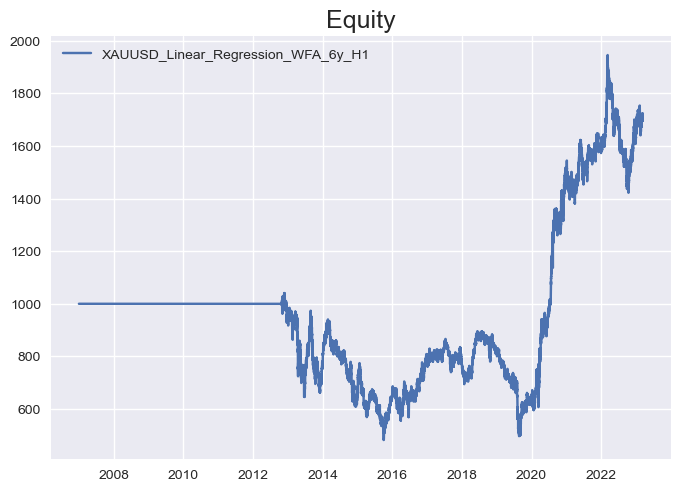

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   56.777368
Equity Final [$]                     1789.424
Equity Peak [$]                      1875.516
Return [%]                            78.9424
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    2.950426
Volatility (Ann.) [%]               16.256698
Sharpe Ratio                          0.18149
Sortino Ratio                        0.269449
Calmar Ratio                         0.060587
Max. Drawdown [%]                  -48.697023
Avg. Drawdown [%]                    -1.60917
Max. Drawdown Duration     1504 days 22:00:00
Avg. Drawdown Duration       21 days 02:00:00
# Trades                                16829
Win Rate [%]                        51.850972
Best Trade [%]                       3.292779
Worst Trade [%]                     -5.251277
Avg. Trade [%]                    

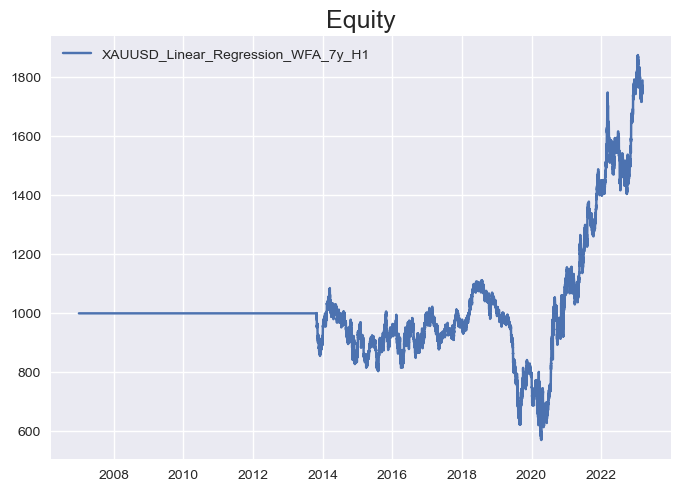

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   50.602852
Equity Final [$]                     1660.775
Equity Peak [$]                      1871.063
Return [%]                            66.0775
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    2.567315
Volatility (Ann.) [%]               13.895968
Sharpe Ratio                         0.184753
Sortino Ratio                        0.271073
Calmar Ratio                         0.066256
Max. Drawdown [%]                   -38.74831
Avg. Drawdown [%]                   -1.772906
Max. Drawdown Duration      817 days 03:00:00
Avg. Drawdown Duration       17 days 01:00:00
# Trades                                17134
Win Rate [%]                        51.499942
Best Trade [%]                       3.319807
Worst Trade [%]                     -5.465692
Avg. Trade [%]                    

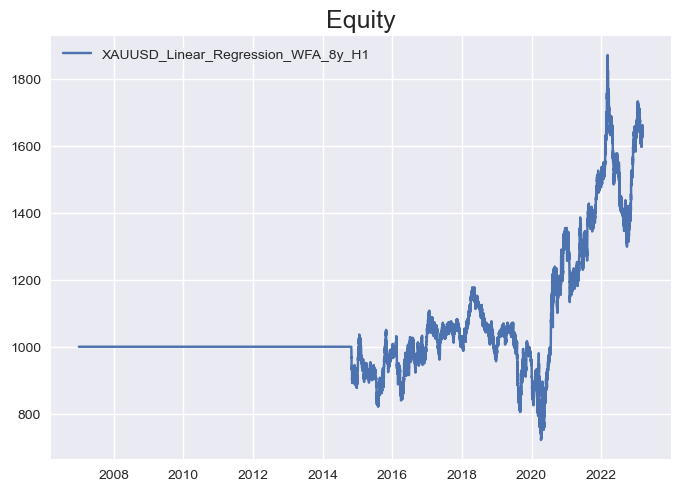

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'M30'

### Window size 1 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   93.803846
Equity Final [$]                     4065.834
Equity Peak [$]                      4536.773
Return [%]                           306.5834
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    7.260388
Volatility (Ann.) [%]                9.712781
Sharpe Ratio                         0.747509
Sortino Ratio                        1.211647
Calmar Ratio                         0.301248
Max. Drawdown [%]                  -24.101071
Avg. Drawdown [%]                   -0.486226
Max. Drawdown Duration      962 days 02:30:00
Avg. Drawdown Duration        5 days 09:53:00
# Trades                                46911
Win Rate [%]                        50.823901
Best Trade [%]                      25.708837
Worst Trade [%]                     -8.712892
Avg. Trade [%]                    

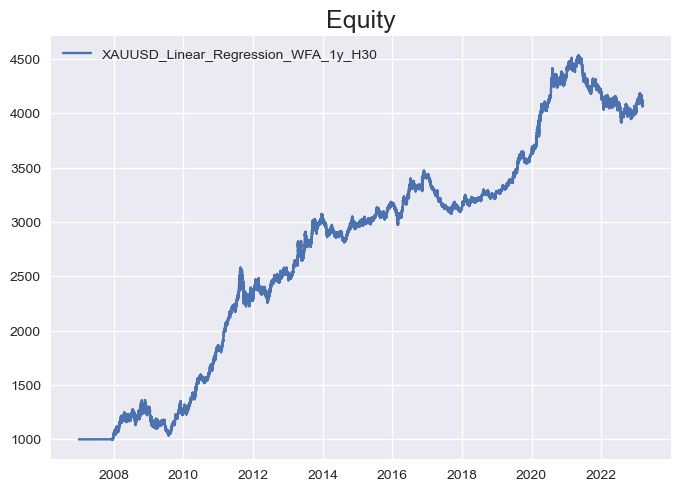

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   87.608203
Equity Final [$]                     3583.581
Equity Peak [$]                      3866.192
Return [%]                           258.3581
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    6.585806
Volatility (Ann.) [%]               10.405987
Sharpe Ratio                         0.632886
Sortino Ratio                        0.997117
Calmar Ratio                         0.277432
Max. Drawdown [%]                  -23.738489
Avg. Drawdown [%]                   -0.516004
Max. Drawdown Duration      627 days 16:00:00
Avg. Drawdown Duration        6 days 09:24:00
# Trades                                35991
Win Rate [%]                        50.573755
Best Trade [%]                      19.299221
Worst Trade [%]                     -6.414788
Avg. Trade [%]                    

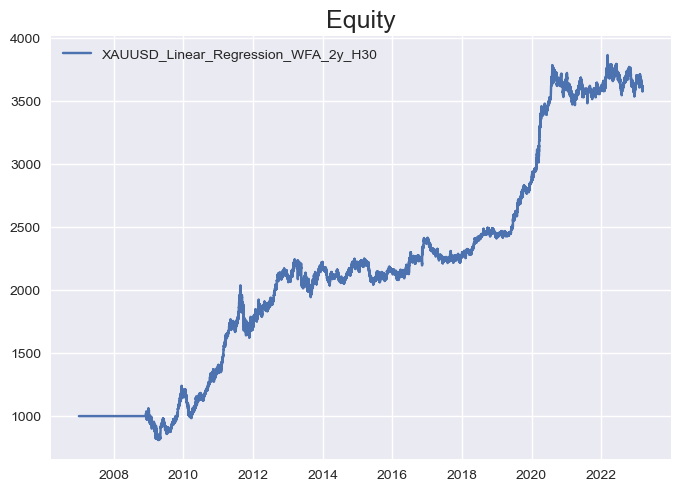

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   81.412561
Equity Final [$]                     2729.285
Equity Peak [$]                      2862.222
Return [%]                           172.9285
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    5.145206
Volatility (Ann.) [%]                10.10606
Sharpe Ratio                         0.509121
Sortino Ratio                        0.782334
Calmar Ratio                         0.231554
Max. Drawdown [%]                  -22.220303
Avg. Drawdown [%]                   -0.708453
Max. Drawdown Duration     2532 days 19:30:00
Avg. Drawdown Duration       10 days 07:56:00
# Trades                                33117
Win Rate [%]                        49.986412
Best Trade [%]                      23.796404
Worst Trade [%]                     -4.826401
Avg. Trade [%]                    

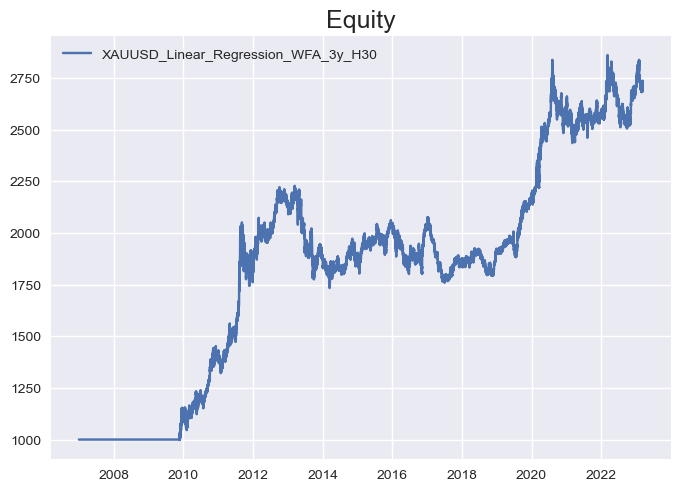

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   75.216919
Equity Final [$]                     2200.313
Equity Peak [$]                      2310.268
Return [%]                           120.0313
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    4.019326
Volatility (Ann.) [%]               13.121188
Sharpe Ratio                         0.306323
Sortino Ratio                        0.446442
Calmar Ratio                         0.106078
Max. Drawdown [%]                  -37.890221
Avg. Drawdown [%]                   -1.185953
Max. Drawdown Duration     1412 days 22:30:00
Avg. Drawdown Duration       15 days 00:57:00
# Trades                                29891
Win Rate [%]                        49.723997
Best Trade [%]                      25.102915
Worst Trade [%]                    -19.264098
Avg. Trade [%]                    

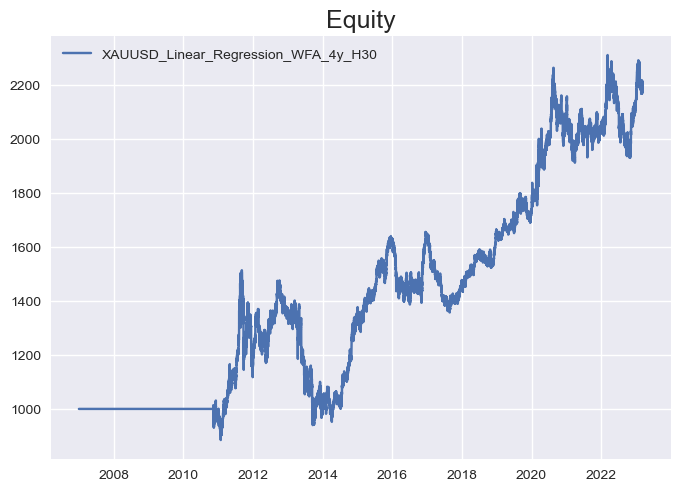

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   69.021277
Equity Final [$]                      1738.05
Equity Peak [$]                      1874.609
Return [%]                             73.805
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    2.800677
Volatility (Ann.) [%]               18.207019
Sharpe Ratio                         0.153824
Sortino Ratio                        0.225164
Calmar Ratio                         0.048946
Max. Drawdown [%]                  -57.219984
Avg. Drawdown [%]                   -1.954379
Max. Drawdown Duration     1479 days 21:30:00
Avg. Drawdown Duration       27 days 19:46:00
# Trades                                28085
Win Rate [%]                        49.784583
Best Trade [%]                       6.737506
Worst Trade [%]                     -9.810541
Avg. Trade [%]                    

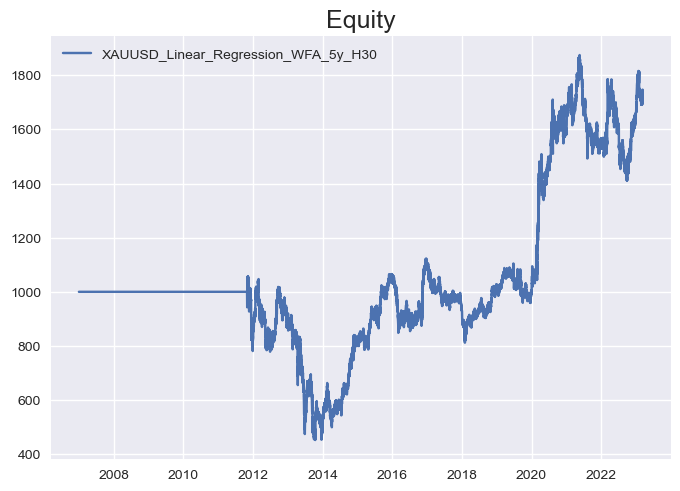

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   62.825635
Equity Final [$]                     1659.586
Equity Peak [$]                      1754.476
Return [%]                            65.9586
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    2.563644
Volatility (Ann.) [%]               17.731503
Sharpe Ratio                         0.144581
Sortino Ratio                        0.206337
Calmar Ratio                         0.053404
Max. Drawdown [%]                   -48.00447
Avg. Drawdown [%]                   -1.935866
Max. Drawdown Duration     2658 days 21:00:00
Avg. Drawdown Duration       28 days 04:33:00
# Trades                                20971
Win Rate [%]                        50.460159
Best Trade [%]                       6.943857
Worst Trade [%]                     -7.679804
Avg. Trade [%]                    

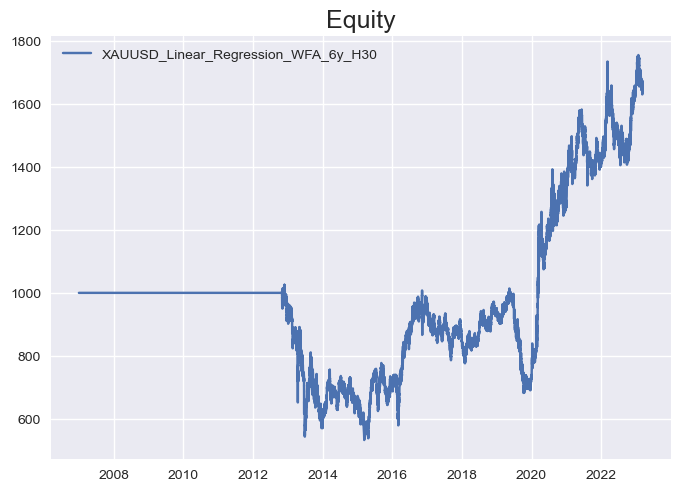

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   56.629993
Equity Final [$]                      889.934
Equity Peak [$]                      1287.515
Return [%]                           -11.0066
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                   -0.580999
Volatility (Ann.) [%]               15.915411
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -50.908688
Avg. Drawdown [%]                   -1.135472
Max. Drawdown Duration     1667 days 16:00:00
Avg. Drawdown Duration       25 days 10:33:00
# Trades                                21800
Win Rate [%]                        50.261468
Best Trade [%]                      10.432804
Worst Trade [%]                    -11.008967
Avg. Trade [%]                    

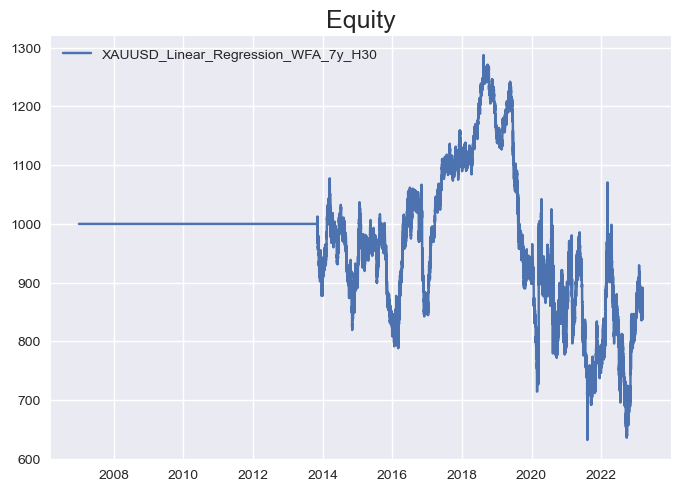

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   50.434351
Equity Final [$]                     1443.136
Equity Peak [$]                      1515.818
Return [%]                            44.3136
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    1.849904
Volatility (Ann.) [%]               12.686856
Sharpe Ratio                         0.145813
Sortino Ratio                        0.226624
Calmar Ratio                         0.067508
Max. Drawdown [%]                  -27.402705
Avg. Drawdown [%]                   -2.145064
Max. Drawdown Duration      769 days 15:30:00
Avg. Drawdown Duration       28 days 22:04:00
# Trades                                19546
Win Rate [%]                        51.094853
Best Trade [%]                       7.762056
Worst Trade [%]                    -15.045329
Avg. Trade [%]                    

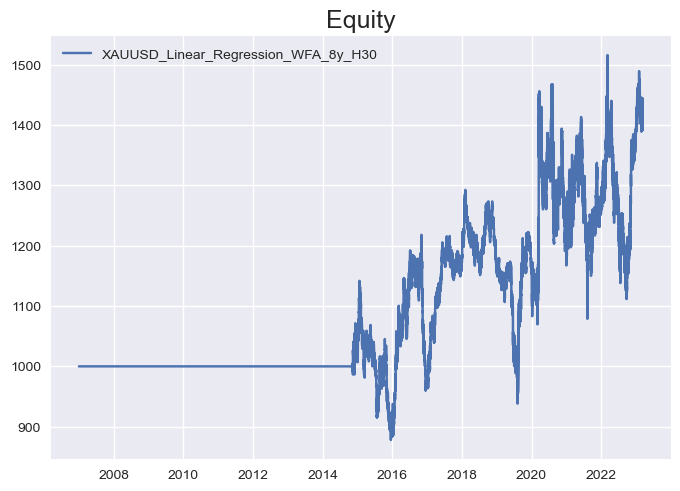

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')